In [1]:
%load_ext autoreload
%autoreload 2

from helper import *
from scipy.stats import skew, kurtosis
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from seiz_eeg.dataset import EEGDataset
import torch.nn as nn
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
import random
from sklearn.metrics import f1_score, recall_score, precision_score
from tqdm import tqdm

/Users/tugba/Desktop/EPFL/ee452-nml/.venv/lib/python3.10/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [2]:
data_path = "./data"
DATA_ROOT = Path(data_path)
seed_everything(31)

In [3]:
df = pd.read_csv(DATA_ROOT / "distances_3d.csv")

nodes = sorted(set(df["from"]) | set(df["to"]))
node_to_idx = {name: idx for idx, name in enumerate(nodes)}

N = len(nodes)
dist = np.full((N, N), np.inf)

for _, row in df.iterrows():
    i = node_to_idx[row["from"]]
    j = node_to_idx[row["to"]]
    dist[i, j] = float(row["distance"])

In [4]:
edge_index, edge_attr = build_softmax_thresholded_graph(dist, beta=5, keep_ratio=0.9)

In [5]:
#Creating train and validation Datasets by considering unique patient IDs

clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

clips_tr = clips_tr.copy()
clips_tr['patient_id'] = clips_tr.index.to_series().apply(lambda x: x.split('_')[0])

unique_patients = clips_tr['patient_id'].unique()

np.random.seed(21)
shuffled_patients = np.random.permutation(unique_patients)

val_patients = shuffled_patients[:21]
train_patients = shuffled_patients[21:]

train_df = clips_tr[clips_tr['patient_id'].isin(train_patients)].reset_index(drop=False)
val_df = clips_tr[clips_tr['patient_id'].isin(val_patients)].reset_index(drop=False)

print(f"Train patients: {train_df['patient_id'].nunique()}, Samples: {len(train_df)}")
print(f"Val patients: {val_df['patient_id'].nunique()}, Samples: {len(val_df)}")

train_df.drop(columns=['patient_id'], inplace=True)
train_df.set_index('id', inplace=True)
val_df.drop(columns=['patient_id'], inplace=True)
val_df.set_index('id', inplace=True)

Train patients: 76, Samples: 10277
Val patients: 21, Samples: 2716


In [6]:
#Load datasets with different preprocessing methods

train_fft = EEGDataset(
    train_df,
    signals_root=DATA_ROOT / "train",
    signal_transform= fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

train_handcrafted = EEGDataset(
    train_df,
    signals_root=DATA_ROOT / "train",
    signal_transform= lambda x: handcrafted_features(x, with_fft = False),
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

train_handcrafted_with_fft = EEGDataset(
    train_df,
    signals_root=DATA_ROOT / "train",
    signal_transform= lambda x: handcrafted_features(x, with_fft = True),
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

val_fft = EEGDataset(
    val_df,
    signals_root=DATA_ROOT / "train",
    signal_transform= fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

val_handcrafted = EEGDataset(
    val_df,
    signals_root=DATA_ROOT / "train",
    signal_transform= lambda x: handcrafted_features(x, with_fft = False),
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

val_handcrafted_with_fft = EEGDataset(
    val_df,
    signals_root=DATA_ROOT / "train",
    signal_transform= lambda x: handcrafted_features(x, with_fft = True),
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [7]:
#Custom Dataset class for EEG data with graph structure

class EEGGraphDataset(Dataset):
    def __init__(self, data, edge_index, edge_attr, is_train=True):
        super().__init__()
        self.num_samples = len(data)
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.data = data
        self.is_train = is_train

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx][0].T, dtype=torch.float32)  # Simulated signal
        y = int(self.data[idx][1]) # Target label if training, else ID
        if self.is_train:
            return Data(x=x, edge_index=self.edge_index, edge_attr=self.edge_attr, y=torch.tensor([[y]], dtype=torch.float32))
        else:
            return Data(x=x, edge_index=self.edge_index, edge_attr=self.edge_attr, id=y)

In [8]:
# Define the MPNN layer and model

from torch_geometric.utils import softmax
class DistanceMPNNLayer(MessagePassing):
    def __init__(self, in_channels, hidden_channels):
        super().__init__(aggr='mean')  # mean aggregation
        self.mlp_msg = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
        )
        self.att_mlp = nn.Sequential(
            nn.Linear(2 * in_channels, 1)  # computes raw attention score
        )
        self.mlp_update = nn.Sequential(
            nn.Linear(in_channels + hidden_channels, hidden_channels),
            nn.LayerNorm(hidden_channels),
            nn.ReLU()
        )
        self.norm = nn.LayerNorm(hidden_channels)

    def forward(self, x, edge_index):
        return self.mlp_update(torch.cat([x, self.propagate(edge_index=edge_index, x=x)], dim=-1))

    def message(self, x_i, x_j, index):
        # Compute attention scores from concatenated [x_i || x_j]
        att_input = torch.cat([x_i, x_j], dim=-1)
        att_scores = self.att_mlp(att_input).squeeze(-1)

        # Softmax normalization per target node (index)
        att_weights = softmax(att_scores, index)

        # Compute message ψ(X_j) and weight it by attention α
        return att_weights.view(-1, 1) * self.mlp_msg(x_j)


class DistanceMPNN(nn.Module):
    def __init__(self, in_channels, hidden_channels_1, hidden_channels_2, hidden_channels_3):
        super().__init__()
        self.first = DistanceMPNNLayer(in_channels, hidden_channels_1)
        self.second = DistanceMPNNLayer(hidden_channels_1, hidden_channels_2)
        self.third = DistanceMPNNLayer(hidden_channels_2, hidden_channels_3)
        self.final_mlp = nn.Linear(hidden_channels_3, 1)


    def forward(self, x, edge_index, batch):
        return self.final_mlp(global_mean_pool(self.third(self.second(self.first(x, edge_index), edge_index),edge_index), batch))

### ONLY FFT

In [27]:
train_dataset = EEGGraphDataset(train_fft, edge_index=edge_index, edge_attr=edge_attr, is_train=True)
val_dataset = EEGGraphDataset(val_fft, edge_index=edge_index, edge_attr=edge_attr, is_train=True)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistanceMPNN(in_channels=train_fft[0][0].shape[0], hidden_channels_1=128, hidden_channels_2=64, hidden_channels_3=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 200
train_losses = []
val_losses = []
val_f1s = []

In [30]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(logits, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, batch.batch)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            yb = batch.y
            loss = criterion(logits, yb)
            val_loss += loss.item()

            # Flatten and collect predictions and labels
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(batch.y.view(-1).cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    f1 = f1_score(all_labels, all_preds)
    val_f1s.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {f1:.4f}")

Epoch 1/200 - Train Loss: 0.4969, Val Loss: 0.6073, Val F1: 0.0000
Epoch 2/200 - Train Loss: 0.4815, Val Loss: 0.6089, Val F1: 0.0000
Epoch 3/200 - Train Loss: 0.4749, Val Loss: 0.6112, Val F1: 0.0000
Epoch 4/200 - Train Loss: 0.4693, Val Loss: 0.6142, Val F1: 0.0000
Epoch 5/200 - Train Loss: 0.4650, Val Loss: 0.6175, Val F1: 0.0000
Epoch 6/200 - Train Loss: 0.4615, Val Loss: 0.6211, Val F1: 0.0000
Epoch 7/200 - Train Loss: 0.4590, Val Loss: 0.6249, Val F1: 0.0000
Epoch 8/200 - Train Loss: 0.4572, Val Loss: 0.6287, Val F1: 0.0000
Epoch 9/200 - Train Loss: 0.4546, Val Loss: 0.6322, Val F1: 0.0000
Epoch 10/200 - Train Loss: 0.4538, Val Loss: 0.6358, Val F1: 0.0000
Epoch 11/200 - Train Loss: 0.4529, Val Loss: 0.6366, Val F1: 0.0000
Epoch 12/200 - Train Loss: 0.4523, Val Loss: 0.6422, Val F1: 0.0000
Epoch 13/200 - Train Loss: 0.4515, Val Loss: 0.6446, Val F1: 0.0000
Epoch 14/200 - Train Loss: 0.4510, Val Loss: 0.6474, Val F1: 0.0000
Epoch 15/200 - Train Loss: 0.4499, Val Loss: 0.5934, Val 

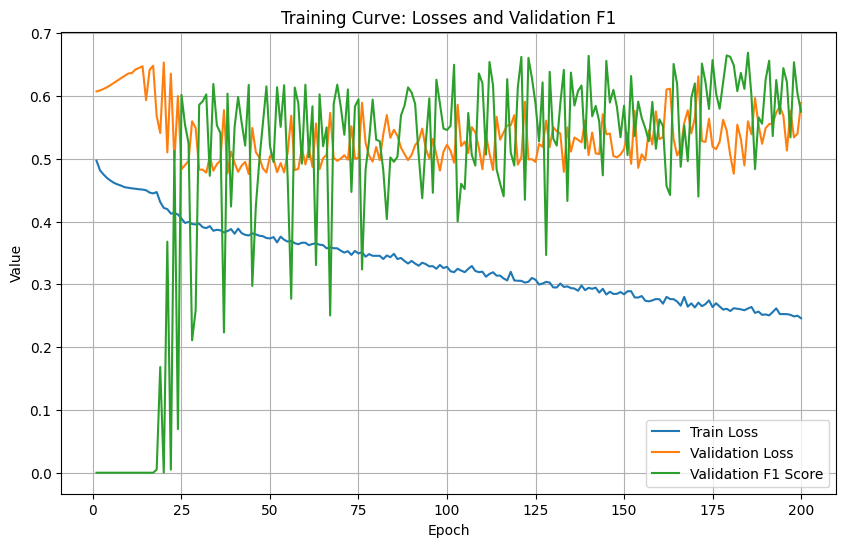

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Curve: Losses and Validation F1")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
max(val_f1s[:200])

0.6689265536723163

### ONLY HANDCRAFTED FEATURES

In [11]:
train_dataset = EEGGraphDataset(train_handcrafted, edge_index=edge_index, edge_attr=edge_attr, is_train=True)
val_dataset = EEGGraphDataset(val_handcrafted, edge_index=edge_index, edge_attr=edge_attr, is_train=True)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistanceMPNN(in_channels=train_handcrafted[0][0].shape[0], hidden_channels_1=128, hidden_channels_2=64, hidden_channels_3=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 200
train_losses = []
val_losses = []
val_f1s = []

In [16]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(logits, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, batch.batch)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            yb = batch.y
            loss = criterion(logits, yb)
            val_loss += loss.item()

            # Flatten and collect predictions and labels
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(batch.y.view(-1).cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    f1 = f1_score(all_labels, all_preds)
    val_f1s.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {f1:.4f}")

Epoch 1/200 - Train Loss: 0.6073, Val Loss: 0.6073, Val F1: 0.0000
Epoch 2/200 - Train Loss: 0.4823, Val Loss: 0.6124, Val F1: 0.0000
Epoch 3/200 - Train Loss: 0.4626, Val Loss: 0.6148, Val F1: 0.0000
Epoch 4/200 - Train Loss: 0.4566, Val Loss: 0.6103, Val F1: 0.0000
Epoch 5/200 - Train Loss: 0.4515, Val Loss: 0.5999, Val F1: 0.0000
Epoch 6/200 - Train Loss: 0.4442, Val Loss: 0.5841, Val F1: 0.0197
Epoch 7/200 - Train Loss: 0.4359, Val Loss: 0.5602, Val F1: 0.0438
Epoch 8/200 - Train Loss: 0.4296, Val Loss: 0.5701, Val F1: 0.0580
Epoch 9/200 - Train Loss: 0.4219, Val Loss: 0.5550, Val F1: 0.0857
Epoch 10/200 - Train Loss: 0.4149, Val Loss: 0.5388, Val F1: 0.1452
Epoch 11/200 - Train Loss: 0.4076, Val Loss: 0.5693, Val F1: 0.1168
Epoch 12/200 - Train Loss: 0.4021, Val Loss: 0.5555, Val F1: 0.1343
Epoch 13/200 - Train Loss: 0.3991, Val Loss: 0.5762, Val F1: 0.1254
Epoch 14/200 - Train Loss: 0.3946, Val Loss: 0.5719, Val F1: 0.1363
Epoch 15/200 - Train Loss: 0.3906, Val Loss: 0.5516, Val 

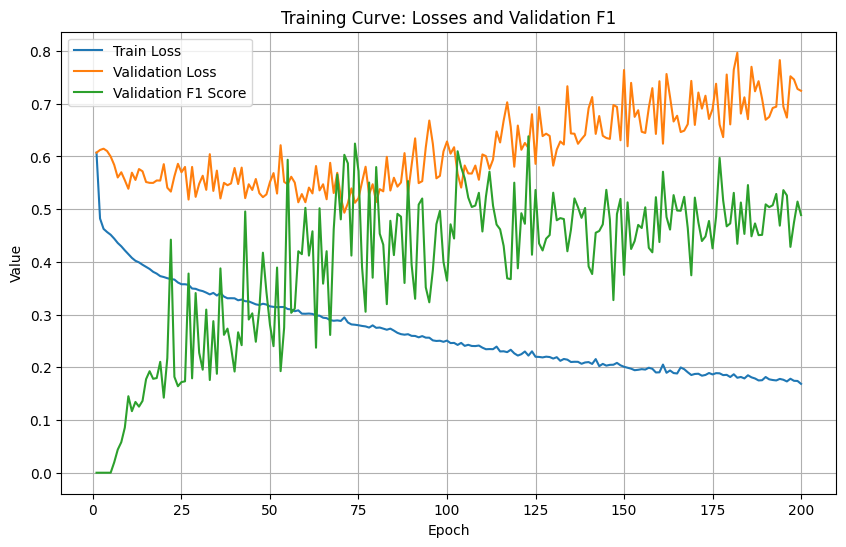

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Curve: Losses and Validation F1")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
max(val_f1s)

0.6382743362831859

### FFT + HANDCRAFTED FEATURES

In [19]:
train_dataset = EEGGraphDataset(train_handcrafted_with_fft, edge_index=edge_index, edge_attr=edge_attr, is_train=True)
val_dataset = EEGGraphDataset(val_handcrafted_with_fft, edge_index=edge_index, edge_attr=edge_attr, is_train=True)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistanceMPNN(in_channels=train_handcrafted_with_fft[0][0].shape[0], hidden_channels_1=128, hidden_channels_2=64, hidden_channels_3=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 200
train_losses = []
val_losses = []
val_f1s = []

In [22]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(logits, batch.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, batch.batch)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            yb = batch.y
            loss = criterion(logits, yb)
            val_loss += loss.item()

            # Flatten and collect predictions and labels
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(batch.y.view(-1).cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    f1 = f1_score(all_labels, all_preds)
    val_f1s.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {f1:.4f}")

Epoch 1/200 - Train Loss: 0.5165, Val Loss: 0.6313, Val F1: 0.0000
Epoch 2/200 - Train Loss: 0.4469, Val Loss: 0.5931, Val F1: 0.0000
Epoch 3/200 - Train Loss: 0.4302, Val Loss: 0.5287, Val F1: 0.0124
Epoch 4/200 - Train Loss: 0.4136, Val Loss: 0.4805, Val F1: 0.5152
Epoch 5/200 - Train Loss: 0.4031, Val Loss: 0.4902, Val F1: 0.4398
Epoch 6/200 - Train Loss: 0.3930, Val Loss: 0.5075, Val F1: 0.1644
Epoch 7/200 - Train Loss: 0.3840, Val Loss: 0.4917, Val F1: 0.3271
Epoch 8/200 - Train Loss: 0.3748, Val Loss: 0.4765, Val F1: 0.5447
Epoch 9/200 - Train Loss: 0.3704, Val Loss: 0.5109, Val F1: 0.2025
Epoch 10/200 - Train Loss: 0.3656, Val Loss: 0.4888, Val F1: 0.3355
Epoch 11/200 - Train Loss: 0.3587, Val Loss: 0.4517, Val F1: 0.5689
Epoch 12/200 - Train Loss: 0.3541, Val Loss: 0.4501, Val F1: 0.5796
Epoch 13/200 - Train Loss: 0.3495, Val Loss: 0.5015, Val F1: 0.2430
Epoch 14/200 - Train Loss: 0.3490, Val Loss: 0.4590, Val F1: 0.5130
Epoch 15/200 - Train Loss: 0.3447, Val Loss: 0.4688, Val 

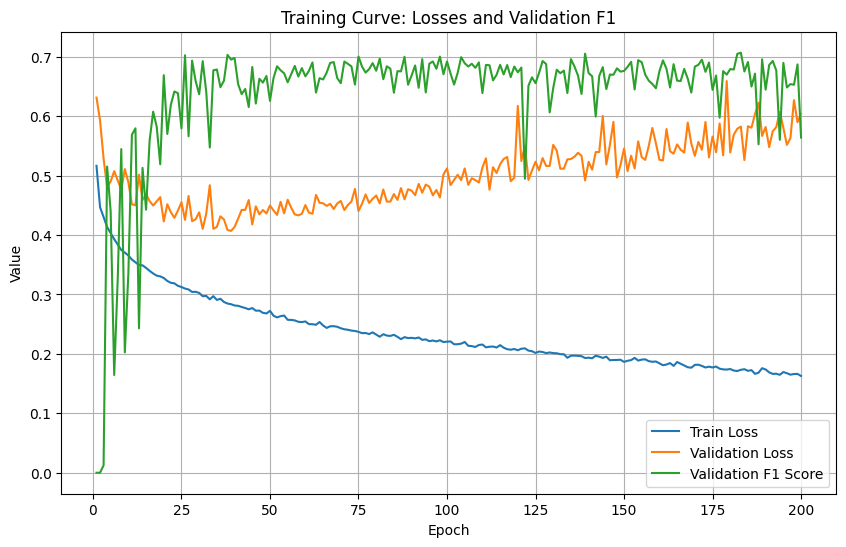

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Curve: Losses and Validation F1")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
max(val_f1s)

0.7068273092369478